<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
## ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_Etivity-2

In [ ]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20157347" #@param {type:"string"}
Student_full_name = "Robert Barrett" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb
from sklearn.model_selection import train_test_split

In [3]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [302]:
path = '/content/sample_data/'

col_names =['ad_id', 'area', 'bathrooms', 'beds', 
            'ber_classification', 'county', 'description_block','environment', 
            'facility', 'features', 'latitude', 'longitude', 'no_of_units',
            'price', 'property_category', 'property_type', 'surface']

train_file = path+'house_train.csv'
test_file = path+'house_test.csv'
true_file = path+'true_price.csv'

train_data = pd.read_csv(train_file, usecols=[i for i in col_names if i not in ['features', 'description_block']])
test_data = pd.read_csv(test_file, usecols=[i for i in col_names if i not in ['features', 'description_block', 'price']])
true_data = pd.read_csv(true_file)

#### Comments
We removed 'features' and ' description_block' from the files as these were free-text fields with no useful information.

In [152]:
print(train_data.shape)
print(test_data.shape)
print(true_data.shape)

(2982, 15)
(500, 14)
(500, 2)


## Exploratory Data Analysis

### Analysis of Training Data - dealing with numeric values

In [153]:
train_data.head(5)

,ad_id,area,bathrooms,beds,ber_classification,county,environment,facility,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,prod,NaN,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,prod,NaN,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,prod,NaN,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,prod,NaN,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,prod,NaN,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [154]:
train_data.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


#### Analysis of results
The above table provides a lot of information for data preparation:

1. **count** is the count of non-NaN values and tells us if there are missing values. We can see a number of the above features have missing values and need further analysis.

2. **min** and **max** show different ranges and as such need to be scaled to the same range. We will do this as part of Data Preparations.


In [155]:
# Check % of missing values in each feature

train_missing = train_data.isnull().sum()*100/len(train_data)
print(train_missing)

ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
environment            0.000000
facility              67.639168
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64


In [156]:
# Let's check for uniqueness in the columns as it seems some columns have only one unique value

print("Unique values in 'county':", train_data.county.unique())
print("Unique values in 'environment':", train_data.environment.unique())

Unique values in 'county': ['Dublin']
Unique values in 'environment': ['prod']


Both of these columns have only one value in them and as such we will also remove these.

#### Analysis of results
The above provides some insight into features that can be dropped. Features that are almost empty can be dropped and features with significant number of missing values can also be dropped. 
**List of features to drop**
1. "ber_classification"
2. "facilities"
3. "no_of_units"
4. 'surface'

Plus the following clumns with only one unique value.
5. 'county'
6. 'environment'

The 'ad_id' is an identifier and, as we will see below in the correlation map, it is not relevant for training to predict a price. It also will be removed from the training set.

In [303]:
# Drop columns where there is significant missing data

train_data.drop(['ad_id','ber_classification', 'facility', 'no_of_units', 'surface', 'county', 'environment'], axis=1, inplace=True)


In [304]:
# List columns again
train_missing = train_data.isnull().sum()*100/len(train_data)
print(train_missing)

area                 0.000000
bathrooms            1.710262
beds                 1.710262
latitude             0.000000
longitude            0.000000
price                3.018109
property_category    0.000000
property_type        1.710262
dtype: float64


The columns now left are in good shape except for a few that have a small percentage of missing vales. Because the % missing is small, we will just remove these rows before further processing.

In [305]:
# Remove full row instances where there are missing values

df_train = train_data.dropna()

In [306]:
# Let's look at features that may have nonsense values

# Remove instances where 'bedrooms' or 'bathrooms' is zero

df_train = df_train.drop(df_train[(df_train.bathrooms==0) | (df_train.beds==0)].index)

In [307]:
# Look at values of 'longitude' and 'latitude' that do not make sense, i.e. outliers

outliers = df_train[(df_train.longitude > -6) | (df_train.latitude < 53)]

outliers.head()

,area,bathrooms,beds,latitude,longitude,price,property_category,property_type
767,Clondalkin,1.0,3.0,52.501856,-1.744995,199000.0,sale,semi-detached
861,Glenageary,2.0,4.0,51.458439,-2.496219,795000.0,sale,semi-detached


#### **Comment**
The locations with these coordinates are not in the areas indicated.
The Clondalkin location has coordinates for Birmingham.
The Glenageary location has coordinates for Bristol.

We will remove these two ouliers.

In [308]:
df_train = df_train.drop(df_train[(df_train.longitude > -6) | (df_train.latitude < 53)].index)

In [309]:
# Let's see how many training instances are left after clean up

print("Number of training instances remaining: ", df_train.shape)

train_missing = df_train.isnull().sum()*100/len(df_train)
print(train_missing)

Number of training instances remaining:  (2826, 8)
area                 0.0
bathrooms            0.0
beds                 0.0
latitude             0.0
longitude            0.0
price                0.0
property_category    0.0
property_type        0.0
dtype: float64


#### Comments
From above we have removed columns and rows to improve the quality of the data set. We have 

1. Reduced the number of columns from 16 to 8
2. We have reduced the number of records/instances from 2982 to 2826.

The reduction in number of data instances is small and is unlikely to affect the outcome. Reducing the number of columns is a good start.

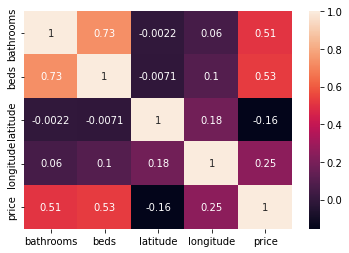

In [164]:
# Let's look at any correlations between numeric values in the df_train data

sb.heatmap(df_train.corr(), annot=True)

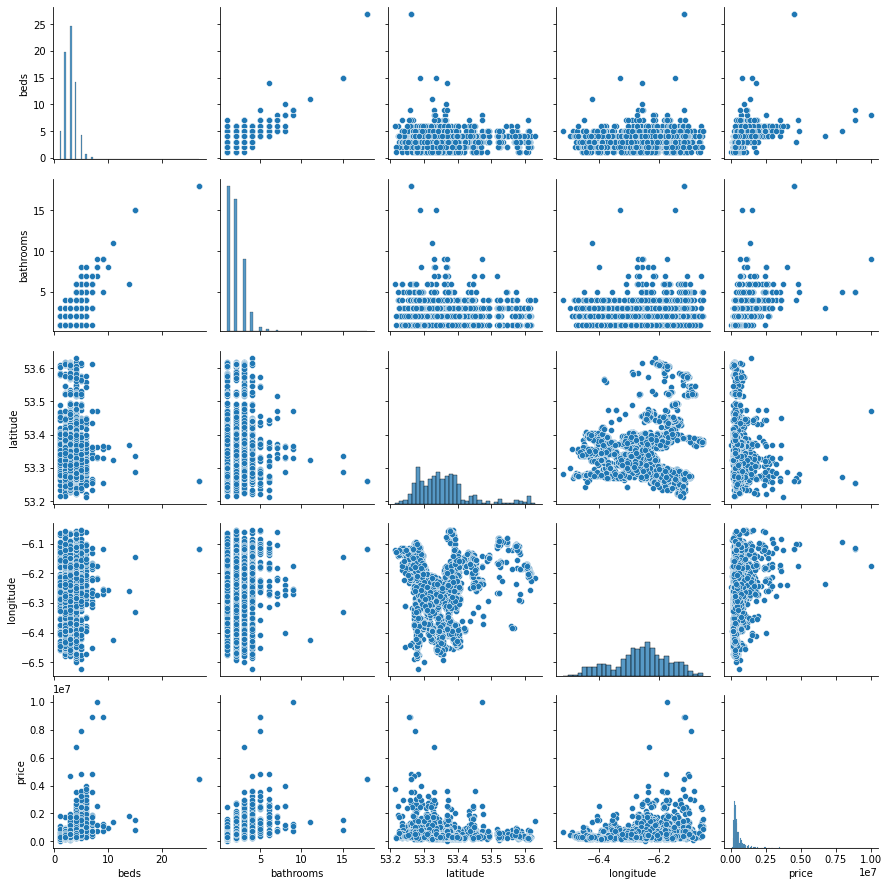

In [52]:
# Let's take a closer look at som eof these correlations

sb.pairplot(data=df_train[['beds','bathrooms', 'latitude', 'longitude', 'price']])

#### Comments
We can see a positive correlation between the 'price' and 'bathrooms' and 'beds'. These are clearly important for price.

It is interesting to see that the latitude seems to have a slight negative impact on price and the longitude has a slightly positive impact (from Heatmap). This can be attributed to the dynamics of Dublin prices impacted by location, i.e. there is a distinct cultural driver in North/West versus South Dublin prices.

We will extact 'price' as our target (y) value for the model training.

### Analysis of Training Data - dealing with categorical values

In [310]:
# Let's deal with Categorical data

# Feature map 'area' first
unique_areas = df_train['area'].unique() # create a list of unique areas
unique_areas_list = np.append(unique_areas, "Kilbarrack")
unique_areas_index = []

# Create a dictionary lookup with Area Name: index pairs for lookup
i = [i+1 for i in range(len(unique_areas_list))]
unique_areas_index = dict(zip(unique_areas_list, i))

# Replace area name with the index from the 'unique_areas_index' dictionary 
df_train_1 = df_train.replace({'area': unique_areas_index})

# Do the same with 'property_type' - there are 12 values here so one-hot-encoding may be a good option here - reduces need for scaling
df_train_1 = pd.get_dummies(df_train_1, columns=['property_type'])

# We are going to map 'property_category' to binary values: it only have two values, it could be one-hot-encoded but it doesn't matter if values are 0,1
mapper_prop_category = {"new_development_parent": 0, "sale": 1}
df_train_1['property_category'] = df_train_1['property_category'].replace(mapper_prop_category)


In [311]:
df_train = df_train_1.copy()
df_train.head()

,area,bathrooms,beds,latitude,longitude,price,property_category,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
15,1,3.0,5.0,53.400454,-6.445730,935000.0,0,0,0,1,0,0,0,0,0,0,0
26,2,4.0,4.0,53.316410,-6.385214,485000.0,0,0,0,0,0,0,1,0,0,0,0
27,1,3.0,5.0,53.401414,-6.446634,935000.0,0,0,0,1,0,0,0,0,0,0,0
35,3,5.0,5.0,53.375377,-6.056749,1475000.0,0,0,0,1,0,0,0,0,0,0,0
38,4,2.0,2.0,53.372130,-6.338466,410000.0,0,1,0,0,0,0,0,0,0,0,0


### Feature distribution and scaling


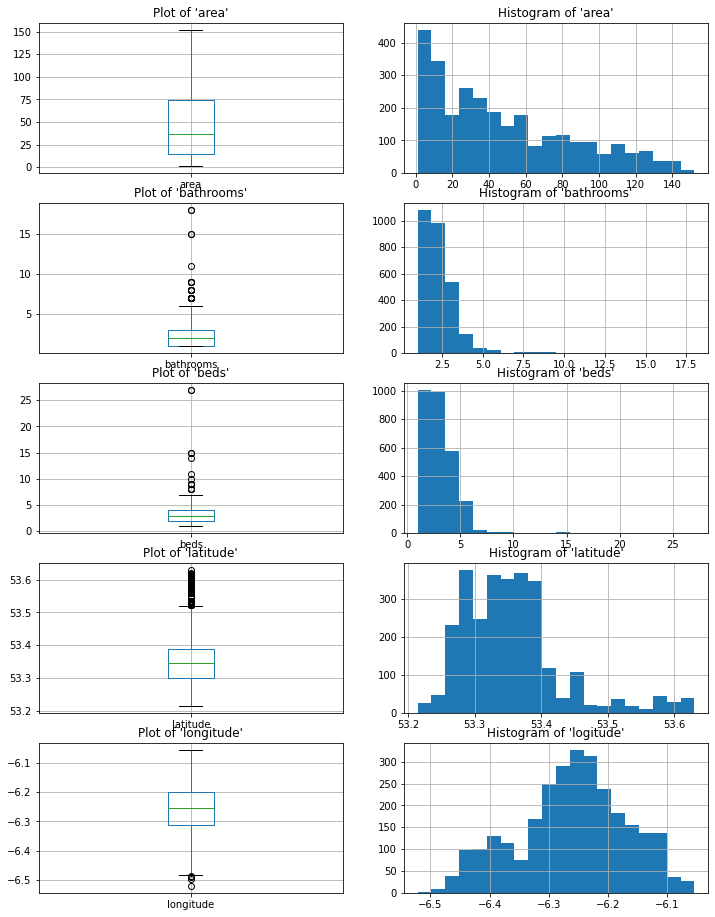

In [285]:
# Let's look at feature distributions and scaling

# First we will look at the distribution of key predictor features

fig = plt.figure(figsize=(12, 16))

ax1 = fig.add_subplot(5, 2, 1)
ax1.set_title("Plot of 'area'")
df_train.boxplot(column=['area'])

ax2 = fig.add_subplot(5, 2, 2)
ax2.set_title("Histogram of 'area'")
df_train['area'].hist(bins=20)

ax3 = fig.add_subplot(5, 2, 3)
ax3.set_title("Plot of 'bathrooms'")
df_train.boxplot(column=['bathrooms'])

ax4 = fig.add_subplot(5, 2, 4)
ax4.set_title("Histogram of 'bathrooms'")
df_train['bathrooms'].hist(bins=20)

ax5 = fig.add_subplot(5, 2, 5)
ax5.set_title("Plot of 'beds'")
df_train.boxplot(column=['beds'])

ax6 = fig.add_subplot(5, 2, 6)
ax6.set_title("Histogram of 'beds'")
df_train['beds'].hist(bins=20)

ax7 = fig.add_subplot(5, 2, 7)
ax7.set_title("Plot of 'latitude'")
df_train.boxplot(column=['latitude'])

ax8 = fig.add_subplot(5, 2, 8)
ax8.set_title("Histogram of 'latitude'")
df_train['latitude'].hist(bins=20)

ax9 = fig.add_subplot(5, 2, 9)
ax9.set_title("Plot of 'longitude'")
df_train.boxplot(column=['longitude'])

ax10 = fig.add_subplot(5, 2, 10)
ax10.set_title("Histogram of 'logitude'")
df_train['longitude'].hist(bins=20)


### Analysis of distributions and outliers
The above plots indicate outliers (boxplots) and distributions (histograms) of features. The shapes determine the approach to scaling and outlier handling as follows:

**area** is not Gaussian and can be scaled using a power transform such as Yeo-Johnson to make it more Gaussian-like

**bathrooms** and **beds** have relatively significant outliers and should be treated with the Log Transform

**latitude** and **longitude** have outliers but can be treated with the Standard Scaler.

We will apply these treatments next.

In [312]:
# Apply scalers for distribution and outlier handling

# Scaling 'area' with Box-Cox to rescale from left skewed to more normal distribution (perfect for non-negative values)
from sklearn.preprocessing import PowerTransformer

bc_scaler = PowerTransformer(method='box-cox')
df_train[['area']] = bc_scaler.fit_transform(df_train[['area']])

# Scaling 'bathrooms' and 'beds'
df_train['bathrooms'] = np.log(df_train['bathrooms'])
df_train['beds'] = np.log(df_train['beds'])

# Scaling 'latitude' and 'longitude'

standard_scaler = StandardScaler()

df_train[['latitude', 'longitude']] = standard_scaler.fit_transform(df_train[['latitude', 'longitude']])


In [313]:
df_train.head()

,area,bathrooms,beds,latitude,longitude,price,property_category,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
15,-2.148164,1.098612,1.609438,0.577429,-2.012990,935000.0,0,0,0,1,0,0,0,0,0,0,0
26,-1.906751,1.386294,1.386294,-0.517530,-1.354206,485000.0,0,0,0,0,0,0,1,0,0,0,0
27,-2.148164,1.098612,1.609438,0.589936,-2.022832,935000.0,0,0,0,1,0,0,0,0,0,0,0
35,-1.737305,1.609438,1.609438,0.250714,2.221459,1475000.0,0,0,0,1,0,0,0,0,0,0,0
38,-1.602360,0.693147,0.693147,0.208411,-0.845311,410000.0,0,1,0,0,0,0,0,0,0,0,0


#### Comments
The above data is now processed to ensure all predictor features are scaled them same.

In [314]:
# Apply all preprocessing to the test dataset

# Drop irrelevant columns from test dataset
test_data.drop(['ad_id','ber_classification', 'facility', 'no_of_units', 'surface', 'county', 'environment'], axis=1, inplace=True)

# Drop samples/instances with null values
df_test = test_data.dropna()

# Remove samples/instances with zero values in 'bathrooms' and 'beds'
df_test = df_test.drop(df_test[(df_test.bathrooms==0) | (df_test.beds==0)].index)

# Remove samples/instances where the coordinates are not correct
df_test = df_test.drop(df_test[(df_test.longitude > -6) | (df_test.latitude < 53)].index)

# Replace area name with the index from the 'unique_areas_index' dictionary y
df_test_1 = df_test.replace({'area': unique_areas_index})

# Do the same with 'property_type' - there are 12 values here so one-hot-encoding may be a good option here - reduces need for scaling
df_test_1 = pd.get_dummies(df_test_1, columns=['property_type'])

# We are going to map 'property_category' to binary values: it only have two values, it could be one-hot-encoded but it doesn't matter if values are 0,1
mapper_prop_category = {"new_development_parent": 0, "sale": 1}
df_test_1['property_category'] = df_test_1['property_category'].replace(mapper_prop_category)

df_test = df_test_1.copy()

# Scaling 'area' with Box-Cox to rescale from left skewed to more normal distribution (perfect for non-negative values)
bc_scaler = PowerTransformer(method='box-cox')
df_test[['area']] = bc_scaler.fit_transform(df_test[['area']])

# Scaling 'bathrooms' and 'beds'
df_test['bathrooms'] = np.log(df_test['bathrooms'])
df_test['beds'] = np.log(df_test['beds'])

# Scaling 'latitude' and 'longitude'
standard_scaler = StandardScaler()

df_test[['latitude', 'longitude']] = standard_scaler.fit_transform(df_test[['latitude', 'longitude']])


In [315]:
df_test.head()

,area,bathrooms,beds,latitude,longitude,property_category,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse
0,-0.725206,0.693147,1.386294,2.580195,1.662766,1,0,1,0,0,0,0,0,0,0,0
1,-1.401348,0.693147,1.098612,0.089918,-2.315691,1,0,0,0,0,0,0,0,0,1,0
2,-0.451786,1.098612,1.386294,1.203898,-0.167391,1,0,0,0,0,0,1,0,0,0,0
3,-1.401348,1.386294,1.098612,-0.014999,-2.380588,1,0,0,0,0,0,1,0,0,0,0
4,-2.101455,0.000000,1.098612,-0.233286,-1.644752,1,0,0,0,0,0,1,0,0,0,0


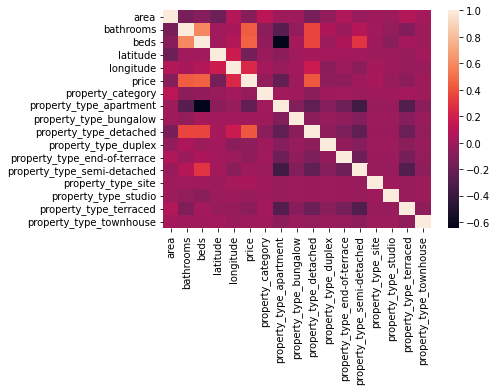

In [243]:
# Let's look at any correlations between numeric values in the df_train data

sb.heatmap(df_train.corr())

####Comments
Based in the correlation matrix above, it is clear that the following may have an imapct on the price of a property:

1. property_type_detached
2. property_type_apartment
3. longitude
4. latitude
5. beds
6. bathrooms
7. area

We wil use these to test the baseline pediction of price.

# PIECEWISE REGRESSION

## Full Model

In [378]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['area', 'bathrooms', 'beds', 'latitude', 'longitude',
            'property_type_apartment', 'property_type_detached', 'price']
featest = ['area','bathrooms', 'beds', 'latitude', 'longitude',
            'property_type_apartment', 'property_type_detached']

df_subset_train = df_train[featrain]
df_subset_test = df_test[featest]
df_cost =  true_data[true_data.index.isin(df_subset_test.index)]

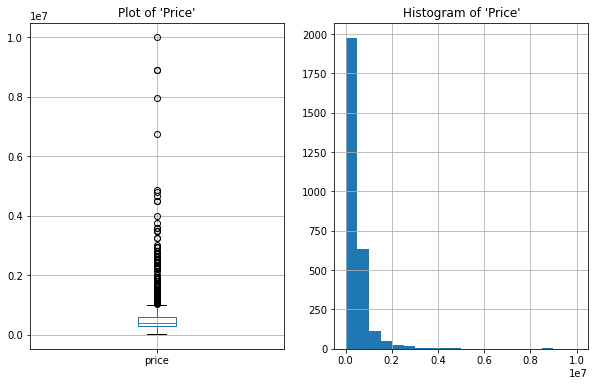

In [355]:
# Let's look at the distribution of property prices from training data

fig = plt.figure(figsize=(10, 6))

ax0 = fig.add_subplot(1, 2, 1)
ax0.set_title("Plot of 'Price'")
df_subset_train.boxplot(column=['price'])

ax00 = fig.add_subplot(1, 2, 2)
ax00.set_title("Histogram of 'Price'")
df_subset_train['price'].hist(bins=20)

#### Comment
These data will need to be log and standard scaled.

In [379]:
# Separate training data into target 'y' and predictor 'X' values

# train set, input columns
X_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
y_train = df_subset_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
X_test = df_subset_test.iloc[:,0:].values 
# test set, output column, cost
y_test = df_cost.Expected.values

In [380]:
# Scale y_train 'price' values

ylog = np.log(y_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
y_train = yscaler.transform(ylog)

In [381]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=X_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, X_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_train[:,0])
    

Finished [100%]: Average Loss = 2,629.2


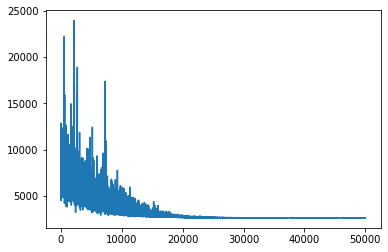

In [382]:
#number of iterations of the algorithms
iter = 50000

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [383]:
# samples from the posterior
posterior = approximation.sample(draws=2000)

In [384]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), X_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  203412.09453346493
MAPE =  0.2643648015412629


### Analysis of first model
The results for MAE and MAPE are very similar for both the reduced feature set above and the full set of features. Adding in or reoving any other feature reduced the performance of the model, sometimes considerably. We will use this measure of performance a our baseline.

## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)


### Clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY